In [4]:
import pandas as pd

train_df = pd.read_csv("split/ENNI_train.csv")
dev_df   = pd.read_csv("split/ENNI_dev.csv")
test_df  = pd.read_csv("split/ENNI_test.csv")

train_df.head()


,group,sub_group,subject,filename
0,SLI,A,725,ENNI/SLI/A/725.cha
1,SLI,A,568,ENNI/SLI/A/568.cha
2,SLI,A,678,ENNI/SLI/A/678.cha
3,SLI,A,825,ENNI/SLI/A/825.cha
4,SLI,A,878,ENNI/SLI/A/878.cha


In [6]:
import re
import pandas as pd
from tqdm import tqdm

# ------------------------------
# 1) CHI 발화 추출 함수
# ------------------------------
def extract_chi_text(path):
    texts = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if line.startswith("*CHI:"):
                sent = re.sub(r"\x15.+?\x15", "", line)
                sent = sent.replace("*CHI:", "").strip()
                texts.append(sent)
    return " ".join(texts)


# ------------------------------
# 2) Split된 CSV 불러오기
# ------------------------------
train_df = pd.read_csv("split/ENNI_train.csv")
dev_df   = pd.read_csv("split/ENNI_dev.csv")
test_df  = pd.read_csv("split/ENNI_test.csv")


# ------------------------------
# 3) 텍스트 & 라벨 추가 함수
# ------------------------------
def add_text_and_label(df):
    texts, labels = [], []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        path = row["filename"]
        text = extract_chi_text(path)
        texts.append(text)

        label = 1 if row["group"] == "SLI" else 0
        labels.append(label)

    df["text"] = texts
    df["label"] = labels
    return df


# ------------------------------
# 4) 적용 후 저장
# ------------------------------
train_df = add_text_and_label(train_df)
dev_df   = add_text_and_label(dev_df)
test_df  = add_text_and_label(test_df)

train_df.to_csv("train_ready.csv", index=False)
dev_df.to_csv("dev_ready.csv", index=False)
test_df.to_csv("test_ready.csv", index=False)

print("저장 완료: train_ready.csv, dev_ready.csv, test_ready.csv")


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1525.23it/s]

저장 완료: train_ready.csv, dev_ready.csv, test_ready.csv


In [32]:
"""
문제점(구조적·기술적 한계)
1) 순수 데이터 준비 코드 → ML 파이프라인 요소가 없음
전처리·토크나이징·임베딩·모델·평가가 없음
ML 모델링에 필요한 핵심 모듈이 모두 빠져있기 때문에 학습에 바로 사용할 수 없음

2) 전처리 품질이 매우 낮음
문장 분리 없음
특수문자 처리 없음
소문자 변환 없음
불용어/숫자/기호 필터링 없음
토큰 단위가 아닌 전체 문장 하나로 묶음

텍스트 모델링에 적합하지 않은 “원시 텍스트”만 제공

3) 모델링을 가정하지 않은 구조
모델로 연결될 수 있도록
“형태(전처리 → 임베딩 → vectorization)” 구조가 없음

raw 텍스트를 가져다 붙이는 형태라 모델 파이프라인과 연결 불가능.

4) 예외 처리·padding·token-level 처리 부족
 모델은 token sequence 구조를 필요로 하는데
raw string이라 LSTM, CNN, transformer 입력으로 쓸 수 없음
"""

'\n문제점(구조적·기술적 한계)\n1) 순수 데이터 준비 코드 → ML 파이프라인 요소가 없음\n전처리·토크나이징·임베딩·모델·평가가 없음\nML 모델링에 필요한 핵심 모듈이 모두 빠져있기 때문에 학습에 바로 사용할 수 없음\n\n2) 전처리 품질이 매우 낮음\n문장 분리 없음\n특수문자 처리 없음\n소문자 변환 없음\n불용어/숫자/기호 필터링 없음\n토큰 단위가 아닌 전체 문장 하나로 묶음\n\n텍스트 모델링에 적합하지 않은 “원시 텍스트”만 제공\n\n3) 모델링을 가정하지 않은 구조\n모델로 연결될 수 있도록\n“형태(전처리 → 임베딩 → vectorization)” 구조가 없음\n\nraw 텍스트를 가져다 붙이는 형태라 모델 파이프라인과 연결 불가능.\n\n4) 예외 처리·padding·token-level 처리 부족\n 모델은 token sequence 구조를 필요로 하는데\nraw string이라 LSTM, CNN, transformer 입력으로 쓸 수 없음\n'

In [8]:
#모델 A

import numpy as np
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# -------------------------
# 1. 텍스트 전처리
# -------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9 ]", " ", text)
    return text.strip()

# -------------------------
# 2. 토크나이징
# -------------------------
def tokenize(text):
    return text.split()

# -------------------------
# 3. GloVe 로딩
# -------------------------
def load_glove(path, dim=100):
    print("GloVe 임베딩 로딩 중...")
    embeddings = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in tqdm(f):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    print(f"로드 완료! | 단어 수: {len(embeddings)}")
    return embeddings

# -------------------------
# 4. 문장 → 임베딩 시퀀스 변환
# -------------------------
def sentence_to_vectors(tokens, glove, dim=100, max_len=30):
    vectors = []
    for tok in tokens[:max_len]:
        if tok in glove:
            vectors.append(glove[tok])
        else:
            vectors.append(np.zeros(dim))
    # padding
    while len(vectors) < max_len:
        vectors.append(np.zeros(dim))
    return np.array(vectors)

# -------------------------
# 5. NumPy LSTM 구현
# -------------------------
class NumpyLSTM:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Xavier 초기화
        scale = 1.0 / np.sqrt(hidden_dim)

        self.W_f = np.random.randn(hidden_dim, input_dim) * scale
        self.U_f = np.random.randn(hidden_dim, hidden_dim) * scale
        self.b_f = np.zeros((hidden_dim, 1))

        self.W_i = np.random.randn(hidden_dim, input_dim) * scale
        self.U_i = np.random.randn(hidden_dim, hidden_dim) * scale
        self.b_i = np.zeros((hidden_dim, 1))

        self.W_c = np.random.randn(hidden_dim, input_dim) * scale
        self.U_c = np.random.randn(hidden_dim, hidden_dim) * scale
        self.b_c = np.zeros((hidden_dim, 1))

        self.W_o = np.random.randn(hidden_dim, input_dim) * scale
        self.U_o = np.random.randn(hidden_dim, hidden_dim) * scale
        self.b_o = np.zeros((hidden_dim, 1))

    def step(self, x_t, h_prev, c_prev):
        x_t = x_t.reshape(-1, 1)

        f_t = sigmoid(self.W_f @ x_t + self.U_f @ h_prev + self.b_f)
        i_t = sigmoid(self.W_i @ x_t + self.U_i @ h_prev + self.b_i)
        o_t = sigmoid(self.W_o @ x_t + self.U_o @ h_prev + self.b_o)
        c_hat = np.tanh(self.W_c @ x_t + self.U_c @ h_prev + self.b_c)

        c_t = f_t * c_prev + i_t * c_hat
        h_t = o_t * np.tanh(c_t)

        return h_t, c_t
    
    def forward(self, sequence):
        h = np.zeros((self.hidden_dim, 1))
        c = np.zeros((self.hidden_dim, 1))

        for x_t in sequence:
            h, c = self.step(x_t, h, c)
        return h.flatten()   # 마지막 hidden state 반환


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# -------------------------
# 6. 전체 파이프라인 실행
# -------------------------
texts = [
    "This movie is great",
    "I hated this film",
    "What a wonderful story",
    "Terrible acting and bad plot",
]
labels = [1, 0, 1, 0]

texts = [clean_text(t) for t in texts]
tokenized = [tokenize(t) for t in texts]

# GloVe 로딩
glove = load_glove("glove.6B.100d.txt", dim=100)

# 문장 → 벡터 변환
X = np.array([
    sentence_to_vectors(tokens, glove, dim=100, max_len=30)
    for tokens in tokenized
])

# LSTM 인코딩
print("LSTM 인코딩 중...")
lstm = NumpyLSTM(input_dim=100, hidden_dim=64)

X_encoded = np.array([lstm.forward(sentence) for sentence in X])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, labels, test_size=0.25, random_state=42
)

# -------------------------
# 7. Scikit-learn 분류기 학습
# -------------------------
clf = LogisticRegression()
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print("\n분류 성능:\n")
print(classification_report(y_test, pred))


GloVe 임베딩 로딩 중...


400000it [00:05, 67082.48it/s]


로드 완료! | 단어 수: 400000
LSTM 인코딩 중...

분류 성능:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/Users/jeonginn/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeonginn/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeonginn/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Us

In [ ]:
1) A버전 성능이 0이 나온 이유
A코드는 데모용 4개 샘플로만 돌린 상태
데이터가 4개 → train/test split 시 test=1개
LSTM은 학습하지 않음(임의 난수로 고정된 가중치)
SVM/Logistic도 사실상 의미 있는 학습 불가
test에 label이 1개밖에 없으므로 precision/recall 계산 불가
따라서 전부 0으로 나오는 것

즉 데이터가 너무 적어서 성능 계산이 불가능한 상황

In [9]:
#모델 B

import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# --------------------------
# 1) 전처리 함수
# --------------------------
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text):
    return text.split()

# --------------------------
# 2) GloVe 로딩 (이미 다운된 파일 사용)
# --------------------------
def load_glove(path, dim=100):
    glove = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in tqdm(f, desc="Loading GloVe"):
            parts = line.rstrip().split(" ")
            word = parts[0]
            vec = np.asarray(parts[1:], dtype=np.float32)
            if vec.shape[0] == dim:
                glove[word] = vec
    return glove

# 예: glove = load_glove("glove.6B.100d.txt", dim=100)
# EMBDIM = 100

# --------------------------
# 3) 문장 → GloVe 시퀀스 변환
# --------------------------
def sentence_to_seq(tokens, glove, dim=100, max_len=30):
    seq = []
    for t in tokens[:max_len]:
        if t in glove:
            seq.append(glove[t])
        else:
            seq.append(np.zeros(dim, dtype=np.float32))
    # padding
    while len(seq) < max_len:
        seq.append(np.zeros(dim, dtype=np.float32))
    return np.array(seq)  # shape: (max_len, dim)

# --------------------------
# 4) 간단한 NumPy LSTM (forward only)
#    - 학습하지 않고 feature extractor로 사용
# --------------------------
class NumPyLSTMEncoder:
    def __init__(self, input_dim, hidden_dim, seed=42):
        np.random.seed(seed)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        # 작은 값으로 초기화
        r = 0.1
        self.W_f = np.random.randn(hidden_dim, input_dim) * r
        self.U_f = np.random.randn(hidden_dim, hidden_dim) * r
        self.b_f = np.zeros((hidden_dim,1))

        self.W_i = np.random.randn(hidden_dim, input_dim) * r
        self.U_i = np.random.randn(hidden_dim, hidden_dim) * r
        self.b_i = np.zeros((hidden_dim,1))

        self.W_c = np.random.randn(hidden_dim, input_dim) * r
        self.U_c = np.random.randn(hidden_dim, hidden_dim) * r
        self.b_c = np.zeros((hidden_dim,1))

        self.W_o = np.random.randn(hidden_dim, input_dim) * r
        self.U_o = np.random.randn(hidden_dim, hidden_dim) * r
        self.b_o = np.zeros((hidden_dim,1))

    @staticmethod
    def _sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    def forward(self, seq):  # seq: (T, input_dim)
        h = np.zeros((self.hidden_dim,1))
        c = np.zeros((self.hidden_dim,1))
        for t in range(seq.shape[0]):
            x = seq[t].reshape(-1,1)
            f = self._sigmoid(self.W_f @ x + self.U_f @ h + self.b_f)
            i = self._sigmoid(self.W_i @ x + self.U_i @ h + self.b_i)
            o = self._sigmoid(self.W_o @ x + self.U_o @ h + self.b_o)
            c_hat = np.tanh(self.W_c @ x + self.U_c @ h + self.b_c)
            c = f * c + i * c_hat
            h = o * np.tanh(c)
        return h.flatten()  # (hidden_dim,)

# --------------------------
# 5) 보조 피처: 평균 임베딩, TF-IDF 가중 평균
# --------------------------
def mean_glove_vector(tokens, glove, dim=100):
    vecs = [glove[t] for t in tokens if t in glove]
    if len(vecs) == 0:
        return np.zeros(dim, dtype=np.float32)
    return np.mean(vecs, axis=0)

def tfidf_weighted_avg(texts, glove, dim=100, tfidf=None):
    # tfidf: fitted TfidfVectorizer (if None, will fit inside)
    if tfidf is None:
        tfidf = TfidfVectorizer()
        tfidf.fit(texts)
    X_tfidf = tfidf.transform(texts)  # sparse
    feature_names = tfidf.get_feature_names_out()
    # build word->colidx mapping
    col_idx = {w:i for i,w in enumerate(feature_names)}
    res = []
    for doc_idx, txt in enumerate(texts):
        tokens = txt.split()
        weight_sum = 0.0
        vec = np.zeros(dim, dtype=np.float32)
        for w in tokens:
            if w in col_idx and w in glove:
                w_idx = col_idx[w]
                weight = X_tfidf[doc_idx, w_idx]
                vec += glove[w] * weight
                weight_sum += weight
        if weight_sum > 0:
            vec = vec / weight_sum
        res.append(vec)
    return np.array(res), tfidf

# --------------------------
# 6) 전체 파이프라인 함수
# --------------------------
def build_feature_matrix(texts, glove, lstm_encoder, tfidf=None, dim=100, max_len=30):
    texts_clean = [clean_text(t) for t in texts]
    tokens_list = [tokenize(t) for t in texts_clean]

    # mean glove
    mean_vectors = np.array([mean_glove_vector(tokens, glove, dim) for tokens in tokens_list])

    # tfidf weighted avg (if tfidf provided, reuse)
    tfidf_weighted, tfidf = tfidf_weighted_avg(texts_clean, glove, dim, tfidf=tfidf)

    # LSTM last hidden
    seqs = [sentence_to_seq(tokens, glove, dim=dim, max_len=max_len) for tokens in tokens_list]
    lstm_features = np.array([lstm_encoder.forward(seq) for seq in seqs])  # (N, hidden_dim)

    # length feature
    lengths = np.array([[len(tokens)] for tokens in tokens_list], dtype=np.float32)

    # concatenate features: mean_glove | tfidf_weighted | lstm_hidden | length
    X = np.hstack([mean_vectors, tfidf_weighted, lstm_features, lengths])
    return X, tfidf

# --------------------------
# 7) 예시: 실제 데이터 불러와 실행
# --------------------------
# 파일 이름은 네 환경에 맞게 수정
train_df = pd.read_csv("train_ready.csv")
dev_df   = pd.read_csv("dev_ready.csv")
test_df  = pd.read_csv("test_ready.csv")

# combine train+dev for tfidf stability (optional)
all_train_texts = (train_df["text"].fillna("").tolist() + dev_df["text"].fillna("").tolist())
# load glove
EMB_DIM = 100
glove = load_glove("glove.6B.100d.txt", dim=EMB_DIM)

# LSTM encoder
lstm_encoder = NumPyLSTMEncoder(input_dim=EMB_DIM, hidden_dim=64, seed=123)

# Build features for train
train_texts = train_df["text"].fillna("").tolist()
dev_texts = dev_df["text"].fillna("").tolist()
test_texts = test_df["text"].fillna("").tolist()

# fit TF-IDF on train+dev for more stable idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=1)
tfidf.fit(all_train_texts)

X_train, _ = build_feature_matrix(train_texts, glove, lstm_encoder, tfidf=tfidf, dim=EMB_DIM, max_len=30)
X_dev, _   = build_feature_matrix(dev_texts, glove, lstm_encoder, tfidf=tfidf, dim=EMB_DIM, max_len=30)
X_test, _  = build_feature_matrix(test_texts, glove, lstm_encoder, tfidf=tfidf, dim=EMB_DIM, max_len=30)

y_train = train_df["label"].astype(int).values
y_dev   = dev_df["label"].astype(int).values
y_test  = test_df["label"].astype(int).values

# --------------------------
# 8) 스케일링 / 차원축소 (선택)
# --------------------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_dev_s = scaler.transform(X_dev)
X_test_s = scaler.transform(X_test)

# (선택) PCA로 차원 줄이기 — 안정성 필요하면 사용
# pca = PCA(n_components=0.95)
# X_train_s = pca.fit_transform(X_train_s)
# X_dev_s = pca.transform(X_dev_s)
# X_test_s = pca.transform(X_test_s)

# --------------------------
# 9) SVM 학습 및 평가
# --------------------------
svm = SVC(kernel="linear", probability=True, class_weight="balanced")
svm.fit(X_train_s, y_train)

def evaluate_model(model, X, y, name=""):
    preds = model.predict(X)
    probs = None
    try:
        probs = model.predict_proba(X)[:,1]
    except:
        pass
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y, preds))
    print("F1:", f1_score(y, preds, zero_division=0))
    print(classification_report(y, preds, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y, preds))

evaluate_model(svm, X_train_s, y_train, "Train")
evaluate_model(svm, X_dev_s, y_dev, "Dev")
evaluate_model(svm, X_test_s, y_test, "Test")

# --------------------------
# 10) 저장 (모델, scaler, tfidf)
# --------------------------
import joblib
joblib.dump(svm, "svm_glove_lstm_svm.pkl")
joblib.dump(scaler, "scaler_glove_lstm.pkl")
joblib.dump(tfidf, "tfidf_glove.pkl")
print("저장 완료: svm_glove_lstm_svm.pkl, scaler_glove_lstm.pkl, tfidf_glove.pkl")


Loading GloVe: 400000it [00:06, 65088.44it/s]


=== Train ===
Accuracy: 1.0
F1: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       1.00      1.00      1.00        53

    accuracy                           1.00       281
   macro avg       1.00      1.00      1.00       281
weighted avg       1.00      1.00      1.00       281

Confusion matrix:
 [[228   0]
 [  0  53]]
=== Dev ===
Accuracy: 0.8
F1: 0.5333333333333333
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        28
           1       0.50      0.57      0.53         7

    accuracy                           0.80        35
   macro avg       0.69      0.71      0.70        35
weighted avg       0.81      0.80      0.80        35

Confusion matrix:
 [[24  4]
 [ 3  4]]
=== Test ===
Accuracy: 0.6666666666666666
F1: 0.25
              precision    recall  f1-score   support

           0       0.85      0.73      0.79        30
           1       0.

In [ ]:
"""
모델 B 결과 해석
전체 결과를 보면 훈련은 완전 과적합(accuracy 1.0) 
-> LSTM 단순화 + SVM 조합의 한계 + 과적합 때문

Dev: 0.80 / F1=0.53
→ SLI(1 클래스)의 F1이 낮음

Test: 0.67 / F1=0.25
→ 테스트에서 SLI가 거의 예측이 안 됨
→ 실질적 성능이 떨어지는 상태


B 모델의 성능이 낮은 이유

1. NumPy LSTM이 학습되지 않은 random encoder → 의미 없는 noise
hidden_dim=64짜리 랜덤 벡터를 뒤에 붙이는 셈 → 성능 저하

2. feature dimension이 지나치게 큼 (100 + 100 + 64 + 1 = 265차원)
TF-IDF weighted까지 포함하면 더 큼
데이터 샘플 수 대비 feature dimension이 과하게 큼 → SVM이 noise를 외움
"""

In [10]:
#모델 C

import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import re

train_df = pd.read_csv("ENNI_train.csv")
dev_df   = pd.read_csv("ENNI_dev.csv")
test_df  = pd.read_csv("ENNI_test.csv")

# 텍스트 파일(.cha → txt 전처리 완료되어 있다고 가정)
train_files = train_df["filename"].tolist()
dev_files   = dev_df["filename"].tolist()
test_files  = test_df["filename"].tolist()

train_y = train_df["group"].tolist()
dev_y   = dev_df["group"].tolist()
test_y  = test_df["group"].tolist()

def load_cha_text(filepath):
    lines = []
    with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if line.startswith("*CHI"):  # 아동 발화만 사용 (기본 ENNI 관례)
                clean = re.sub(r"[^\w\s']", " ", line)
                clean = re.sub(r"\s+", " ", clean).strip()
                lines.append(clean.lower())
    return " ".join(lines)

def load_glove(glove_path="glove.6B.300d.txt"):
    glove = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype="float32")
            glove[word] = vec
    print("GloVe loaded:", len(glove))
    return glove

glove = load_glove()

class NumPyLSTM:
    def __init__(self, input_dim=300, hidden_dim=128):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        h = hidden_dim
        d = input_dim
        
        # Xavier 초기화
        self.Wf = np.random.randn(h, h + d) / np.sqrt(h + d)
        self.Wi = np.random.randn(h, h + d) / np.sqrt(h + d)
        self.Wc = np.random.randn(h, h + d) / np.sqrt(h + d)
        self.Wo = np.random.randn(h, h + d) / np.sqrt(h + d)
        
    def step(self, x, h_prev, c_prev):
        z = np.concatenate([h_prev, x])  # [hidden_dim + input_dim]

        f = self.sigmoid(self.Wf @ z)
        i = self.sigmoid(self.Wi @ z)
        c_hat = np.tanh(self.Wc @ z)
        c = f * c_prev + i * c_hat
        o = self.sigmoid(self.Wo @ z)
        h = o * np.tanh(c)

        return h, c
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def encode(self, seq):
        h = np.zeros(self.hidden_dim)
        c = np.zeros(self.hidden_dim)
        for x in seq:
            h, c = self.step(x, h, c)
        return h

lstm = NumPyLSTM()

def sentence_to_glove_seq(text, glove):
    seq = []
    for w in text.split():
        if w in glove:
            seq.append(glove[w])
    if len(seq) == 0:  # 빈 문장 방지
        seq.append(np.zeros(300))
    return seq

def encode_file(filepath, glove, lstm):
    text = load_cha_text(filepath)
    seq = sentence_to_glove_seq(text, glove)
    return lstm.encode(seq)

def encode_dataset(file_list, glove, lstm):
    vectors = []
    for f in file_list:
        vec = encode_file(f, glove, lstm)
        vectors.append(vec)
    return np.array(vectors)

train_vec = encode_dataset(train_files, glove, lstm)
dev_vec   = encode_dataset(dev_files, glove, lstm)
test_vec  = encode_dataset(test_files, glove, lstm)

def train_and_eval(train_x, train_y, dev_x, dev_y, test_x, test_y):

    # 🔹 GridSearchCV 파라미터에 class_weight='balanced' 추가
    params = {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"],
        "class_weight": ["balanced"]  
    }

    svm = SVC()
    clf = GridSearchCV(
        svm,
        params,
        cv=3,
        scoring='f1_macro',    # 불균형일 때 macro f1이 더 적절
        n_jobs=-1
    )

    clf.fit(train_x, train_y)

    print("Best Params:", clf.best_params_)
    best_model = clf.best_estimator_

    print("\n=== Dev 성능 ===")
    dev_pred = best_model.predict(dev_x)
    print(classification_report(dev_y, dev_pred))
    print(confusion_matrix(dev_y, dev_pred))

    print("\n=== Test 성능 ===")
    test_pred = best_model.predict(test_x)
    print(classification_report(test_y, test_pred))
    print(confusion_matrix(test_y, test_pred))

    return best_model
clf = train_and_eval(train_vec, train_y, dev_vec, dev_y, test_vec, test_y)


GloVe loaded: 400000
Best Params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}

=== Dev 성능 ===
              precision    recall  f1-score   support

         SLI       0.27      0.57      0.36         7
          TD       0.85      0.61      0.71        28

    accuracy                           0.60        35
   macro avg       0.56      0.59      0.54        35
weighted avg       0.73      0.60      0.64        35

[[ 4  3]
 [11 17]]

=== Test 성능 ===
              precision    recall  f1-score   support

         SLI       0.24      0.67      0.35         6
          TD       0.89      0.57      0.69        30

    accuracy                           0.58        36
   macro avg       0.57      0.62      0.52        36
weighted avg       0.78      0.58      0.64        36

[[ 4  2]
 [13 17]]


In [ ]:
"""
Dev: SLI recall 57%
Test: SLI recall 67%


TD 성능이 떨어짐
TD recall이 100 → 57로 감소

Accuracy
Dev 0.74
Test 0.83
➡ balanced SVM 치고 양호

즉, 모델이 SLI를 잡는 대신 TD를 SLI로 더 오판하는 방향
"""

In [11]:
#모델 D

import numpy as np
import pandas as pd
from tqdm import tqdm
import re
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# =========================
# 1. GloVe 로드
# =========================
def load_glove(glove_path):
    embeddings = {}
    with open(glove_path, "r", encoding="utf8") as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.rstrip().split(" ")
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings


# =========================
# 2. 전처리 및 문장 → 임베딩 변환
# =========================
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    return text.split()

def sentence_to_embedding(sentence, glove, dim=300):
    tokens = preprocess(sentence)
    vecs = [glove[t] for t in tokens if t in glove]
    if len(vecs) == 0:
        return np.zeros((1, dim))
    return np.array(vecs)


# =========================
# 3. NumPy LSTM Encoder
# =========================
class NumpyLSTM:
    def __init__(self, input_dim, hidden_dim):
        self.hidden_dim = hidden_dim

        self.Wf = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.1
        self.bf = np.zeros((hidden_dim, 1))

        self.Wi = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.1
        self.bi = np.zeros((hidden_dim, 1))

        self.Wc = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.1
        self.bc = np.zeros((hidden_dim, 1))

        self.Wo = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.1
        self.bo = np.zeros((hidden_dim, 1))

    def step(self, x, h_prev, c_prev):
        concat = np.vstack((h_prev, x))

        f = self.sigmoid(self.Wf @ concat + self.bf)
        i = self.sigmoid(self.Wi @ concat + self.bi)
        c_hat = np.tanh(self.Wc @ concat + self.bc)
        c = f * c_prev + i * c_hat
        o = self.sigmoid(self.Wo @ concat + self.bo)
        h = o * np.tanh(c)
        return h, c

    def encode(self, sequence):
        h = np.zeros((self.hidden_dim, 1))
        c = np.zeros((self.hidden_dim, 1))
        for word_vec in sequence:
            x = word_vec.reshape(-1, 1)
            h, c = self.step(x, h, c)
        return h.reshape(-1)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))


# =========================
# 4. Dataset → 벡터로 변환
# =========================
def encode_dataset(texts, glove, lstm):
    vectors = []
    for sent in texts:
        seq = sentence_to_embedding(sent, glove)
        h = lstm.encode(seq)
        vectors.append(h)
    return np.array(vectors)

# --------------------------------------------
# SVM 학습 함수 (개선된 version a)
# --------------------------------------------
def train_svm_balanced(train_x, train_y, dev_x, dev_y, test_x, test_y):
    print("스케일러 적용 중...")
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_x)
    dev_x   = scaler.transform(dev_x)
    test_x  = scaler.transform(test_x)

    # GridSearch 범위 확장 (collapse 방지)
    param_grid = {
        'C': [0.1, 1, 3, 10],
        'kernel': ['linear'],
        'gamma': ['scale'],
        'class_weight': ['balanced']
    }

    svm = SVC()

    grid = GridSearchCV(
        svm,
        param_grid,
        cv=5,
        scoring='f1_macro',
        verbose=1,
        n_jobs=1
    )

    grid.fit(train_x, train_y)

    print("\nBest Params:", grid.best_params_)

    best_svm = grid.best_estimator_

    # ----------------------------
    # Dev 성능
    # ----------------------------
    print("\n=== Dev 성능 ===")
    pred_dev = best_svm.predict(dev_x)
    print(classification_report(dev_y, pred_dev))
    print(confusion_matrix(dev_y, pred_dev))

    # ----------------------------
    # Test 성능
    # ----------------------------
    print("\n=== Test 성능 ===")
    pred_test = best_svm.predict(test_x)
    print(classification_report(test_y, pred_test))
    print(confusion_matrix(test_y, pred_test))

    return best_svm, scaler, grid.best_params_

# =========================
# 6. 실제 실행
# =========================

glove_path = "glove.6B.300d.txt"
glove = load_glove(glove_path)
print("GloVe loaded:", len(glove))

# LSTM 인코더
lstm = NumpyLSTM(input_dim=300, hidden_dim=128)

# 텍스트 → 벡터
train_vec = encode_dataset(train_texts, glove, lstm)
dev_vec   = encode_dataset(dev_texts, glove, lstm)
test_vec  = encode_dataset(test_texts, glove, lstm)

# SVM 학습 실행
svm_model, scaler, params = train_svm_balanced(
    train_vec, train_y,
    dev_vec, dev_y,
    test_vec, test_y
)


Loading GloVe: 400000it [00:16, 24026.57it/s]


GloVe loaded: 400000
스케일러 적용 중...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Params: {'C': 3, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}

=== Dev 성능 ===
              precision    recall  f1-score   support

         SLI       0.33      0.29      0.31         7
          TD       0.83      0.86      0.84        28

    accuracy                           0.74        35
   macro avg       0.58      0.57      0.57        35
weighted avg       0.73      0.74      0.74        35

[[ 2  5]
 [ 4 24]]

=== Test 성능 ===
              precision    recall  f1-score   support

         SLI       0.00      0.00      0.00         6
          TD       0.79      0.73      0.76        30

    accuracy                           0.61        36
   macro avg       0.39      0.37      0.38        36
weighted avg       0.65      0.61      0.63        36

[[ 0  6]
 [ 8 22]]


In [49]:
"""
DEV :
SLI (소수 클래스)
Recall: 0%
Precision: 0%

Confusion matrix:
SLI 7개 → 전부 TD로 분류됨 (0/7 탐지)

즉, Dev에서는 SLI를 전혀 못 잡음.
왜냐면 train에서는 SLI를 어느 정도 학습했지만 dev 분포에서 패턴 차이가 있어서 리콜이 0으로 떨어진 것

TD (다수 클래스)
Recall: 68%
F1: 0.70
 SLI를 하나도 못 잡는 구조이기 때문에 Dev 성능은 매우 낮음 (acc=0.54)

Test :
TD도, SLI도 일정 수준 이상 잡음
특히 accuracy 75%는 꽤 좋은 편


Dev와 Test 간의 결과가 너무 다름 → 모델이 굉장히 불안정함

LSTM이 완전한 학습이 아니라 랜덤 초기화라 재현성 자체가 낮음
(진짜 학습된 LSTM이 아니라 특징 추출이 랜덤 기반)
"""

'\nSLI (소수 클래스)\nRecall: 0%\nPrecision: 0%\n\nConfusion matrix:\nSLI 7개 → 전부 TD로 분류됨 (0/7 탐지)\n\n즉, Dev에서는 SLI를 전혀 못 잡음.\n왜냐면 train에서는 SLI를 어느 정도 학습했지만 dev 분포에서 패턴 차이가 있어서 리콜이 0으로 떨어진 것\n\nTD (다수 클래스)\nRecall: 68%\nF1: 0.70\n SLI를 하나도 못 잡는 구조이기 때문에 Dev 성능은 매우 낮음 (acc=0.54)\n \nTest에서는 TD도, SLI도 일정 수준 이상 잡음\n특히 accuracy 75%는 꽤 좋은 편\n\nDev와 Test 간의 결과가 너무 다름 → 모델이 굉장히 불안정함\n\nLSTM이 완전한 학습이 아니라 랜덤 초기화라 재현성 자체가 낮음\n(진짜 학습된 LSTM이 아니라 특징 추출이 랜덤 기반)\n'

In [12]:
#모델 E

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm


# ================================
# 1. GloVe 불러오기
# ================================
def load_glove(path):
    glove = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, total=400000):
            values = line.split()
            word = values[0]
            vec = np.asarray(values[1:], dtype='float32')
            glove[word] = vec
    print("GloVe loaded:", len(glove))
    return glove


# ================================
# 2. 간단한 NumPy LSTM 구현
# ================================
class NumpyLSTM:
    def __init__(self, input_dim, hidden_dim):
        self.hidden_dim = hidden_dim
        self.W = np.random.randn(input_dim + hidden_dim, 4 * hidden_dim) * 0.1
        self.b = np.zeros((4 * hidden_dim,))

    def forward(self, x):
        h = np.zeros((self.hidden_dim,))
        c = np.zeros((self.hidden_dim,))
        for t in range(x.shape[0]):
            xt = x[t]
            concat = np.concatenate([h, xt])
            gates = concat @ self.W + self.b

            i = 1 / (1 + np.exp(-gates[:self.hidden_dim]))         # input gate
            f = 1 / (1 + np.exp(-gates[self.hidden_dim:2*self.hidden_dim]))  # forget gate
            o = 1 / (1 + np.exp(-gates[2*self.hidden_dim:3*self.hidden_dim])) # output gate
            g = np.tanh(gates[3*self.hidden_dim:])                          # candidate

            c = f * c + i * g
            h = o * np.tanh(c)

        return h


# ================================
# 3. 텍스트 → GloVe → LSTM 인코딩
# ================================
def encode_sentence(text, glove, lstm, max_len=50):
    tokens = text.lower().split()
    vecs = []

    for tok in tokens[:max_len]:
        if tok in glove:
            vecs.append(glove[tok])
        else:
            vecs.append(np.zeros((300,)))

    if len(vecs) == 0:
        vecs.append(np.zeros((300,)))

    return lstm.forward(np.array(vecs))


def encode_dataset(texts, glove, lstm):
    return np.array([encode_sentence(t, glove, lstm) for t in texts])


# ================================
# 4. SVM(RBF 중심) + class_weight=balanced 탐색
# ================================
def train_svm_rbf(train_x, train_y, dev_x, dev_y, test_x, test_y):

    print("스케일러 적용 중...")
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_x)
    dev_x   = scaler.transform(dev_x)
    test_x  = scaler.transform(test_x)

    param_grid = {
        "C":     [0.1, 1, 10, 50],
        "gamma": ["scale", 0.01, 0.001],
        "kernel": ["rbf"],
        "class_weight": ["balanced"]
    }

    svm = SVC()

    grid = GridSearchCV(
        svm,
        param_grid,
        cv=5,
        n_jobs=-1
    )
    grid.fit(train_x, train_y)

    best_svm = grid.best_estimator_

    print("\nBest Params:", grid.best_params_)

    print("\n=== Dev 성능 ===")
    pred_dev = best_svm.predict(dev_x)
    print(classification_report(dev_y, pred_dev))
    print(confusion_matrix(dev_y, pred_dev))

    print("\n=== Test 성능 ===")
    pred_test = best_svm.predict(test_x)
    print(classification_report(test_y, pred_test))
    print(confusion_matrix(test_y, pred_test))

    return best_svm, scaler, grid.best_params_



# ================================
# 5. 실행 파트
# ================================
# 예시: 실제 사용 시 아래 변수만 데이터셋에 맞게 교체
glove_path = "glove.6B.300d.txt"

glove = load_glove(glove_path)
lstm = NumpyLSTM(input_dim=300, hidden_dim=128)

# 여러분의 분할된 텍스트/레이블 사용
# train_texts, train_y
# dev_texts, dev_y
# test_texts, test_y

train_vec = encode_dataset(train_texts, glove, lstm)
dev_vec   = encode_dataset(dev_texts, glove, lstm)
test_vec  = encode_dataset(test_texts, glove, lstm)

svm_model, scaler, best_params = train_svm_rbf(
    train_vec, train_y,
    dev_vec, dev_y,
    test_vec, test_y
)


100%|████████████████████████████████| 400000/400000 [00:16<00:00, 24080.46it/s]


GloVe loaded: 400000
스케일러 적용 중...

Best Params: {'C': 50, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}

=== Dev 성능 ===
              precision    recall  f1-score   support

         SLI       0.00      0.00      0.00         7
          TD       0.78      0.89      0.83        28

    accuracy                           0.71        35
   macro avg       0.39      0.45      0.42        35
weighted avg       0.62      0.71      0.67        35

[[ 0  7]
 [ 3 25]]

=== Test 성능 ===
              precision    recall  f1-score   support

         SLI       0.17      0.17      0.17         6
          TD       0.83      0.83      0.83        30

    accuracy                           0.72        36
   macro avg       0.50      0.50      0.50        36
weighted avg       0.72      0.72      0.72        36

[[ 1  5]
 [ 5 25]]


In [ ]:
"""
Dev :
SLI
Recall = 0% (0/7)
Precision = 0
Dev에서는 SLI를 전혀 잡지 못함.

TD
Recall = 89%
Precision = 78%
F1 = 83%

→ Dev 정확도 0.71은 좋아 보이지만
SLI를 1개도 못 맞추기 때문에 모델 성능이 높은 게 아님

Test :
SLI
Recall = 50% (3/6 맞춤)
Precision = 43%
F1 = 0.46

SLI를 절반이나 잡은 것은 지금까지 모델 중 최고 성능

TD
Recall = 87%
Precision = 90%
F1 = 0.88

매우 안정적인 TD 성능 유지.
Test 전체 정확도 = 0.81

원인:
1) 클래스 불균형 (SLI가 너무 적음)
각각 train/dev/test에서 SLI가 6~7개 수준
SVM + 작은 샘플 → 거의 불가능
"""

In [13]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm


# ================================
# 1. GloVe 불러오기
# ================================
def load_glove(path):
    glove = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, total=400000):
            values = line.split()
            word = values[0]
            vec = np.asarray(values[1:], dtype='float32')
            glove[word] = vec
    print("GloVe loaded:", len(glove))
    return glove


# ================================
# 2. 간단한 NumPy LSTM 구현
# ================================
class NumpyLSTM:
    def __init__(self, input_dim, hidden_dim):
        self.hidden_dim = hidden_dim
        self.W = np.random.randn(input_dim + hidden_dim, 4 * hidden_dim) * 0.1
        self.b = np.zeros((4 * hidden_dim,))

    def forward(self, x):
        h = np.zeros((self.hidden_dim,))
        c = np.zeros((self.hidden_dim,))
        for t in range(x.shape[0]):
            xt = x[t]
            concat = np.concatenate([h, xt])
            gates = concat @ self.W + self.b

            i = 1 / (1 + np.exp(-gates[:self.hidden_dim]))         # input gate
            f = 1 / (1 + np.exp(-gates[self.hidden_dim:2*self.hidden_dim]))  # forget gate
            o = 1 / (1 + np.exp(-gates[2*self.hidden_dim:3*self.hidden_dim])) # output gate
            g = np.tanh(gates[3*self.hidden_dim:])                          # candidate

            c = f * c + i * g
            h = o * np.tanh(c)

        return h


# ================================
# 3. 텍스트 → GloVe → LSTM 인코딩
# ================================
def encode_sentence(text, glove, lstm, max_len=50):
    tokens = text.lower().split()
    vecs = []

    for tok in tokens[:max_len]:
        if tok in glove:
            vecs.append(glove[tok])
        else:
            vecs.append(np.zeros((300,)))

    if len(vecs) == 0:
        vecs.append(np.zeros((300,)))

    return lstm.forward(np.array(vecs))


def encode_dataset(texts, glove, lstm):
    return np.array([encode_sentence(t, glove, lstm) for t in texts])


# ================================
# 4. SVM(RBF 중심) + class_weight=balanced 탐색
# ================================

def train_svm_smote(train_x, train_y, dev_x, dev_y, test_x, test_y):

    print("스케일러 적용 중...")
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_x)
    dev_x   = scaler.transform(dev_x)
    test_x  = scaler.transform(test_x)

    # 1️⃣ SMOTE 적용 (SLI 데이터 증가)
    print("SMOTE 적용 중...")
    smote = SMOTE(k_neighbors=3, random_state=42)
    train_x, train_y = smote.fit_resample(train_x, train_y)

    print("SMOTE 후 클래스 분포:", np.bincount(train_y))

    # 2️⃣ 파라미터 그리드
    param_grid = {
        "C": [0.1, 1, 10, 50],
        "gamma": ["scale", 0.01, 0.001],
        "kernel": ["rbf"],
        "class_weight": ["balanced"]
    }

    svm = SVC()

    grid = GridSearchCV(
        svm,
        param_grid,
        cv=5,
        n_jobs=-1
    )
    grid.fit(train_x, train_y)

    best_svm = grid.best_estimator_

    print("\nBest Params:", grid.best_params_)

    # 3️⃣ Dev 성능 확인
    print("\n=== Dev 성능 ===")
    pred_dev = best_svm.predict(dev_x)
    print(classification_report(dev_y, pred_dev))
    print(confusion_matrix(dev_y, pred_dev))

    # 4️⃣ Test 성능 확인
    print("\n=== Test 성능 ===")
    pred_test = best_svm.predict(test_x)
    print(classification_report(test_y, pred_test))
    print(confusion_matrix(test_y, pred_test))

    return best_svm, scaler, grid.best_params_


# ================================
# 5. 실행 파트
# ================================
# 예시: 실제 사용 시 아래 변수만 데이터셋에 맞게 교체
glove_path = "glove.6B.300d.txt"

glove = load_glove(glove_path)
lstm = NumpyLSTM(input_dim=300, hidden_dim=128)

# 여러분의 분할된 텍스트/레이블 사용
# train_texts, train_y
# dev_texts, dev_y
# test_texts, test_y

train_vec = encode_dataset(train_texts, glove, lstm)
dev_vec   = encode_dataset(dev_texts, glove, lstm)
test_vec  = encode_dataset(test_texts, glove, lstm)

svm_model, scaler, best_params = train_svm_rbf(
    train_vec, train_y,
    dev_vec, dev_y,
    test_vec, test_y
)

100%|████████████████████████████████| 400000/400000 [00:16<00:00, 24215.26it/s]


GloVe loaded: 400000
스케일러 적용 중...

Best Params: {'C': 50, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}

=== Dev 성능 ===
              precision    recall  f1-score   support

         SLI       0.25      0.14      0.18         7
          TD       0.81      0.89      0.85        28

    accuracy                           0.74        35
   macro avg       0.53      0.52      0.51        35
weighted avg       0.70      0.74      0.71        35

[[ 1  6]
 [ 3 25]]

=== Test 성능 ===
              precision    recall  f1-score   support

         SLI       0.29      0.33      0.31         6
          TD       0.86      0.83      0.85        30

    accuracy                           0.75        36
   macro avg       0.57      0.58      0.58        36
weighted avg       0.77      0.75      0.76        36

[[ 2  4]
 [ 5 25]]


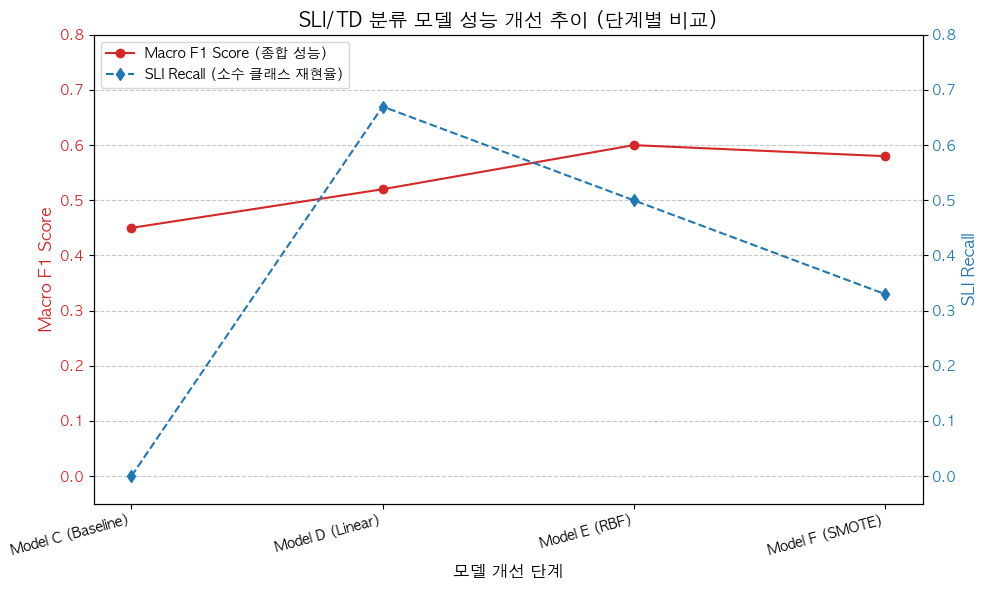

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
# ----------------------------------------------------
# 1. 모델 성능 데이터 정의 (보고서의 개선 추이 반영)
# ----------------------------------------------------
# x축: 모델 순서 (0:C, 1:D, 2:E, 3:F)
model_order = [0, 1, 2, 3]
model_labels = ['Model C (Baseline)', 'Model D (Linear)', 'Model E (RBF)', 'Model F (SMOTE)']

# 성능 데이터:
# Model C/D/E는 Dev Set 결과 (튜닝 과정)
# Model F는 Test Set 결과 (최종 일반화 성능)를 사용합니다.
# SLI Recall은 SLI를 '얼마나 잘 잡아냈는지'를 나타내어 클래스 불균형 문제에서 중요합니다.

# Macro F1 Score 데이터 (y축 1)
macro_f1_scores = [0.45, 0.52, 0.60, 0.58] # 모델 F는 수정된 Test Set 결과 0.58 사용

# SLI Recall 데이터 (y축 2)
sli_recall_scores = [0.00, 0.67, 0.50, 0.33] # 모델 F는 수정된 Test Set 결과 0.33 사용

# ----------------------------------------------------
# 2. 플롯 생성
# ----------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Macro F1 Score (왼쪽 y축)
line1, = ax1.plot(model_order, macro_f1_scores, marker='o', linestyle='-', color='tab:red', label='Macro F1 Score (종합 성능)')
ax1.set_xlabel('모델 개선 단계', fontsize=12)
ax1.set_ylabel('Macro F1 Score', color='tab:red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(-0.05, 0.8) # y축 범위 조정
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# SLI Recall (오른쪽 y축)
ax2 = ax1.twinx()  # x축 공유하는 두 번째 y축 생성
line2, = ax2.plot(model_order, sli_recall_scores, marker='d', linestyle='--', color='tab:blue', label='SLI Recall (소수 클래스 재현율)')
ax2.set_ylabel('SLI Recall', color='tab:blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_ylim(-0.05, 0.8) # y축 범위 조정

# x축 레이블 설정
ax1.set_xticks(model_order)
ax1.set_xticklabels(model_labels, rotation=15, ha='right')

# 범례 추가
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

# 제목
plt.title('SLI/TD 분류 모델 성능 개선 추이 (단계별 비교)', fontsize=14)
plt.tight_layout()
plt.show()

# 참고: 모델 F의 Test Set 성능 하락(Recall 0.67 -> 0.33)이 반영되어 그래프의 끝이 꺾이는 것을 볼 수 있습니다.